## Neural Network implementation for finding defects in semiconductor manufacturing

In [6]:
# All the imports
import numpy as np
import random
import matplotlib.pyplot as plt

import matplotlib
import cv2

### Simulated Data generation with random noise

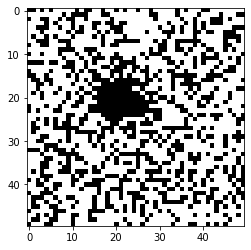

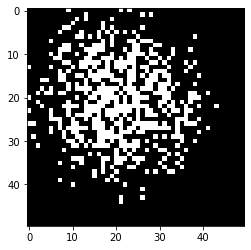

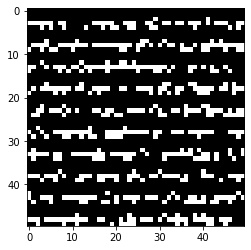

In [23]:
%matplotlib inline
""" 3 different class of data
    1) Spot : p(x, y) = exp(r^2 / 2 * sigma^2), r^2 = (x - xc)^2 + (y - yc)^2, sigma => to vary width of spot
    2) Ring : p(x, y) = 1 - exp(r^2 / 2 * sigma^2), r^2 = (x - xc)^2 + (y - yc)^2
    3) Repititive (Horizontal)
"""

def spot_prob(x, y, sigma, xc, yc) :
    rsquare = (x - xc) ** 2 + (y - yc) ** 2
    return min(1, (np.random.random() * 0.75 + np.exp(-rsquare / 2 * (sigma ** 2))))

def ring_prob(x, y, sigma, xc, yc) :
    rsquare = (x - xc) ** 2 + (y - yc) ** 2
    return min(1, (np.random.random() * 0.75 + 1 - np.exp(-rsquare / 2 * (sigma ** 2))))

def repititive_horizontal_prob(x, y, T, phi) :
    return min(1, (np.random.random() * 0.75 + (1 + np.sin(2 * np.pi * x / T + phi)) / 2))

def plot_grayscale(image) :
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 1)
    plt.show()

def spot_gen(R, C, sigma, xc, yc) :
    # generate a spot
    spot = np.zeros((R, C))
    for i in range(R) :
        for j in range(C) :
            spot[i][j] = 1 - spot_prob(i, j, sigma, xc, yc)
            spot[i][j] = 1 if spot[i][j] > 0.5 else 0
    return spot

spot = spot_gen(50, 50, 0.3, 20, 20)
plot_grayscale(spot)

def ring_gen(R, C, sigma, xc, yc) :
    ring = np.zeros((R, C))
    for i in range(R) :
        for j in range(C) :
            ring[i][j] = 1 - ring_prob(i, j, sigma, xc, yc)
            ring[i][j] = 1 if ring[i][j] > 0.5 else 0
    return ring

ring = ring_gen(50, 50, 0.05, 20.5, 20.5)
plot_grayscale(ring)

def repititive_horizontal_gen(R, C, T, phi) :
    rh = np.zeros((R, C))
    for i in range(R) :
        for j in range(C) :
            rh[i][j] = 1 - repititive_horizontal_prob(i, j, T, phi)
            rh[i][j] = 1 if rh[i][j] > 0.5 else 0
    return rh

rh = repititive_horizontal_gen(50, 50, 5, np.pi / 4)
plot_grayscale(rh)
    

### Data Loader

In [8]:
# def load_data():
#     # open dataset load the data and return
#     f = gzip.open('mnist.pkl.gz', 'rb')
#     training_data, validation_data, test_data = pickle.load(f, encoding = 'latin1')
#     f.close()
#     return (training_data, validation_data, test_data)

# def load_data_wrapper():
#     # modify the dataset according to the need
#     tr_d, va_d, te_d = load_data()
#     training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
#     training_results = [vectorized_result(y) for y in tr_d[1]]
#     training_data = list(zip(training_inputs, training_results))
#     validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
#     validation_data = list(zip(validation_inputs, va_d[1]))
#     test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
#     test_data = list(zip(test_inputs, te_d[1]))
#     return (training_data, validation_data, test_data)

# def vectorized_result(j):
#     e = np.zeros((10, 1))
#     e[j] = 1.0
#     return e

# Generate dataset (training_data, test_data)
no_of_training_data = 5000
no_of_test_data = 1000

training_data = []
test_data = []
R = 50
C = 50

for it in range(no_of_training_data + no_of_test_data) :
    index = np.random.randint(0, 3)
#     print(index)
    if(index == 0) :
        xc = np.random.randint(R // 4, 3 * R // 4)
        yc = np.random.randint(C // 4, 3 * C // 4)
        sigma = np.random.random() * 0.75 + 0.1 # optimal range of sigma -> [0.1, 0.5)
        spot = spot_gen(R, C, sigma, xc, yc)
#         plot_grayscale(spot)
        spot_input = np.reshape(spot, (R * C, 1))
        spot_output = np.zeros((3, 1))
        spot_output[index] = 1
        if(it < no_of_training_data) :
            training_data.append((spot_input, spot_output))
        else :
            test_data.append((spot_input, index))
    elif (index == 1) :
        xc = np.random.randint(R // 4, 3 * R // 4)
        yc = np.random.randint(C // 4, 3 * C // 4)
        sigma = np.random.random() * 0.5 # optimal range of sigma -> [0.03, 0.2)
        ring = ring_gen(R, C, sigma, xc, yc)
#         plot_grayscale(ring)
        ring_input = np.reshape(ring, (R * C, 1))
        ring_output = np.zeros((3, 1))
        ring_output[index] = 1
        if(it < no_of_training_data) :
            training_data.append((ring_input, ring_output))
        else :
            test_data.append((ring_input, index))
    else :
        assert(index == 2)
        # pick T anything from 3 to 15
        T = 25 * np.random.random() + 3
        phi = np.pi / 2 * np.random.random()
        rh = repititive_horizontal_gen(R, C, T, phi)
#         plot_grayscale(rh)
        rh_input = np.reshape(rh, (R * C, 1))
        rh_output = np.zeros((3, 1))
        rh_output[index] = 1
        if(it < no_of_training_data) :
            training_data.append((rh_input, rh_output))
        else :
            test_data.append((rh_input, index))
            
# check the final sizes of traning_data and test_data
assert(len(training_data) == no_of_training_data)
assert(len(test_data) == no_of_test_data)

### Neural Network

In [9]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation. 
"""

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

### Running the neural network

In [11]:
# training_data, validation_data, test_data = load_data_wrapper()

net = Network([R * C, 30, 3])
net.SGD(training_data, 20, 10, 2, test_data)

Epoch 0: 918 / 1000
Epoch 1: 940 / 1000
Epoch 2: 943 / 1000
Epoch 3: 945 / 1000
Epoch 4: 947 / 1000
Epoch 5: 948 / 1000
Epoch 6: 950 / 1000
Epoch 7: 957 / 1000
Epoch 8: 956 / 1000
Epoch 9: 958 / 1000
Epoch 10: 960 / 1000
Epoch 11: 955 / 1000
Epoch 12: 960 / 1000
Epoch 13: 961 / 1000
Epoch 14: 961 / 1000
Epoch 15: 962 / 1000
Epoch 16: 960 / 1000
Epoch 17: 964 / 1000
Epoch 18: 963 / 1000
Epoch 19: 962 / 1000
